In [1]:
import os

import sys
sys.path.insert(0, "./utils/")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import emcee
import corner

import autotransit as au

import shutil as sh

In [2]:
toi_file="TOI_2020.09.08_14.21.51.csv" #nexsci catalogue for TOI parameters 

toi=2143.01 #The TOI we want to work with.

exocat=au.readtoicsv(toi_file) #get catalogue info

In [3]:
toi=2143.01
toi_index = [j for j, x in enumerate(exocat.toiid) if x == toi][0]
print('TIC ID: ',exocat.ticid[toi_index],'| TOI ID: ',exocat.toiid[toi_index])

TIC ID:  103195323 | TOI ID:  2143.01


In [6]:
def check_mcmc(toi_id,resultsdir,nbin,nthin,burninfrac,modeltype):
    
    filedir=resultsdir+'toi'+str(int(toi_id))+'.n/'

    chain=[]
    sol=[]
    phot=[] #TDB..
    
    #chainfile=koi_dir+'chain_ld_'+str(koi_id)+'.h5' #MCMC results.  Stored in an HDF5 file
    chainfile=filedir+'chain_'
    if modeltype[0]==1:
        chainfile+='ld_'
    if modeltype[1]==1:
        chainfile+='rh_'
    if modeltype[2]==1:
        chainfile+='ec_'
    if modeltype[3]==1:
        chainfile+='gpm32_'
    chainfile+=str(toi_id)+'.h5' #MCMC results are stored in an HDF5 file
    print('chainfile: ',chainfile)
    
    npl=int(100*(0.001+toi_id-np.floor(toi_id))) #planet number
    
    #nfile = koi_dir+'n_ld_'+str(npl)+'.dat'
    #read n1.dat file
    nfile=filedir+'n_'
    if modeltype[0]==1:
        nfile+='ld_'
    if modeltype[1]==1:
        nfile+='rh_'
    if modeltype[2]==1:
        nfile+='ec_'
    if modeltype[3]==1:
        nfile+='gpm32_'
    nfile+=str(npl)+'.dat'
    #nfile = koi_dir+'n0.dat'
    print('nfile: ',nfile)
    if os.path.isfile(nfile):
        sol,serr=au.readsol(nfile) #read in a transit solution
        solflag=1
    else:
        solflag=0
    

    if (solflag==1):# & (photflag==1): #need a solution and photometry.

        npars=0 #count number of parameters
        for s in serr:
            if np.abs(s) > 1.0e-30:
                npars+npars+1
        
        #ttfile=[]
        #ttfile.append(koi_dir+'koi'+str(int(koi_id)).zfill(4)+'.0'+str(npl)+'.tt')
        #if os.path.isfile(ttfile[0]):
        #    ntt,tobs,omc = tf.readtt(ttfile) #read in TTVs
        #    ttflag=1
        #else:
        #    ntt=0; tobs=0; omc=0;
        #    ttflag=0
        ntt=0; tobs=0; omc=0;
        ttflag=0
        
        npar_sys=8 #number of system-wide parameters (e.g., limb-darkening)
        npar_pln=10 #planet specific parameters (e.g., r/R*)

        nbodies=int((len(sol)-npar_sys)/npar_pln)
        clabels=['p','c1','c2','q1','q2','DIL','VOF','ZPT','EP','PE','BB','RD','EC','ES','KRV','TED','ELL','ALB']
        ccolours=['black','black','r','orange','b','g','purple','r','orange','b','g','purple','r','orange','b','g',\
                  'purple','r']

        label=[]
        colour=[]
        k=-1
        for j in range(npar_sys):
            k=k+1
            if np.abs(serr[j]) > 1.0e-30:
                label.append(clabels[k])
                colour.append(ccolours[0])
        for i in range(nbodies):
            n=npar_sys-1
            for j in range(npar_pln):
                k=k+1
                n=n+1
                if np.abs(serr[k]) > 1.0e-30:
                    label.append(clabels[n]+str(i+1))
                    colour.append(ccolours[i+2])
                    
        label.append('DSC')
        colour.append('black')
        if modeltype[3]==1:
            label.append('ASC')
            colour.append('black')
            label.append('LSC')
            colour.append('black')
            
        if os.path.isfile(chainfile):
            
            sh.copy(chainfile,"chaintemp.h5")
            chainfile="chaintemp.h5"

            #Read in Chain
            reader = emcee.backends.HDFBackend(chainfile)
            samples = reader.get_chain(flat=True)
            print('Native size: ',len(samples))

            nburnin=len(samples)*burninfrac
            burnin=int(nburnin/nthin) #correct burnin using nthin.

            chain=np.array(samples)
            chain=chain[::nthin,:] #Thin out chain.
            print('Thin size: ',len(chain))
            print('Burnin: ',burnin)
            
            if burnin > 0:
                    burnin_bak=np.copy(burnin)
            else:
                burnin=np.copy(burnin_bak)
            sigcut=4
            niter=3
            for k in range(niter):
                npars=chain.shape[1]
                test=np.copy(chain[burnin:,:])
                for i in range(npars):
                    nch=test.shape[0]
                    #print(nch)
                    mean=np.mean(test[:,i])
                    std=np.std(test[:,i])
                    #print(mean,std)
                    test2=[]
                    for j in range(nch):
                        #print(test[j,i], np.abs(test[j,i]-mean),std*sigcut)
                        #input()
                        if np.abs(test[j,i]-mean) < sigcut*std:
                            test2.append(test[j,:])
                    test=np.array(test2)
                nch=test.shape[0]
                #print("nchains:",nch)
                chain=np.copy(test)
                burnin=0


            chainT = reader.get_chain()[:, :].T
            npt=1000#len(phot.time)
            burninfrac=0.5
            Rc=au.gelmanrubin(chainT,burninfrac,npt) #npt is number of data points
            print('Rc:',Rc)
            
            npars=len(chain[1,:])
            mm=np.zeros(npars)
            for i in range(0,npars):
                mode,x_eval,kde1=au.modekdestimate(chain[:,i],burnin)
                mm[i]=mode
                perc1 = au.intperc(mode,x_eval,kde1)#,perc=0.997)
                
                precision=int((np.floor( np.min(( np.log10(np.abs(perc1[1]-mode)), np.log10(np.abs(mode-perc1[0])))))))
                if precision <= 0:
                    precision=np.abs(precision)+1
                else:
                    precision=0
                print("{:5s} = ".format(label[i]), "{:0.{prec}f}".format(mode,prec=precision),\
                "{:0.{prec}f}".format(np.abs(perc1[1]-mode),prec=precision),\
                "{:0.{prec}f}".format(np.abs(mode-perc1[0]),prec=precision))
                
                #print('%s = %.8f +%.8f -%.8f (1 Sigma)' %(label[i],mode,np.abs(perc1[1]-mode),np.abs(mode-perc1[0])))

            au.histplots(chain,sol,serr,burnin,nbin,label,colour)

            au.plotchains(chain,label,colour,burnin,psize=10.5)
            
            x=[]
            nparsol=len(sol)
            for i in range(nparsol):
                if abs(serr[i])>1.0e-30:
                    if i==0:
                        x.append(np.log(sol[i]))
                    else:
                        x.append(sol[i])
            x.append(1.0)
            if modeltype[3]==1:
                x.append(1.0)
                x.append(1.0)
            x=np.array(x)
            figure = corner.corner(chain[burnin:],labels=label,quantiles=[0.16, 0.5, 0.84],\
                                   show_titles=True)
                                  #truths=x,truth_color='red',show_titles=True)


chainfile:  ./results/toi2143.n/chain_ld_2143.01.h5
nfile:  ./results/toi2143.n/n_ld_1.dat
Native size:  1338300
Thin size:  13797
Burnin:  6898
Rc: [1.08182262 1.03258439 1.03246006 1.03715719 1.03015828 1.03859112
 1.08843988 1.04840861 1.03354402]
p     =  0.360 0.016 0.061
q1    =  0.232 0.011 0.011
q2    =  0.148 0.029 0.023
ZPT   =  -0.000034 0.000057 0.000071
EP1   =  2012.01525 0.00058 0.00062
PE1   =  5.58966 0.00019 0.00021
BB1   =  0.306 0.095 0.245
RD1   =  0.07278 0.00068 0.00084
DSC   =  1.644 0.023 0.025


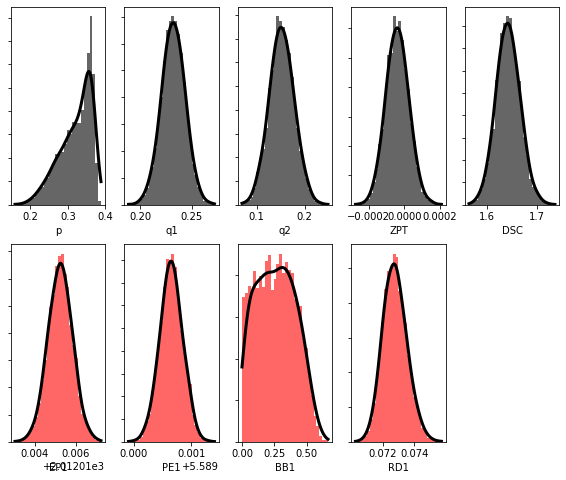

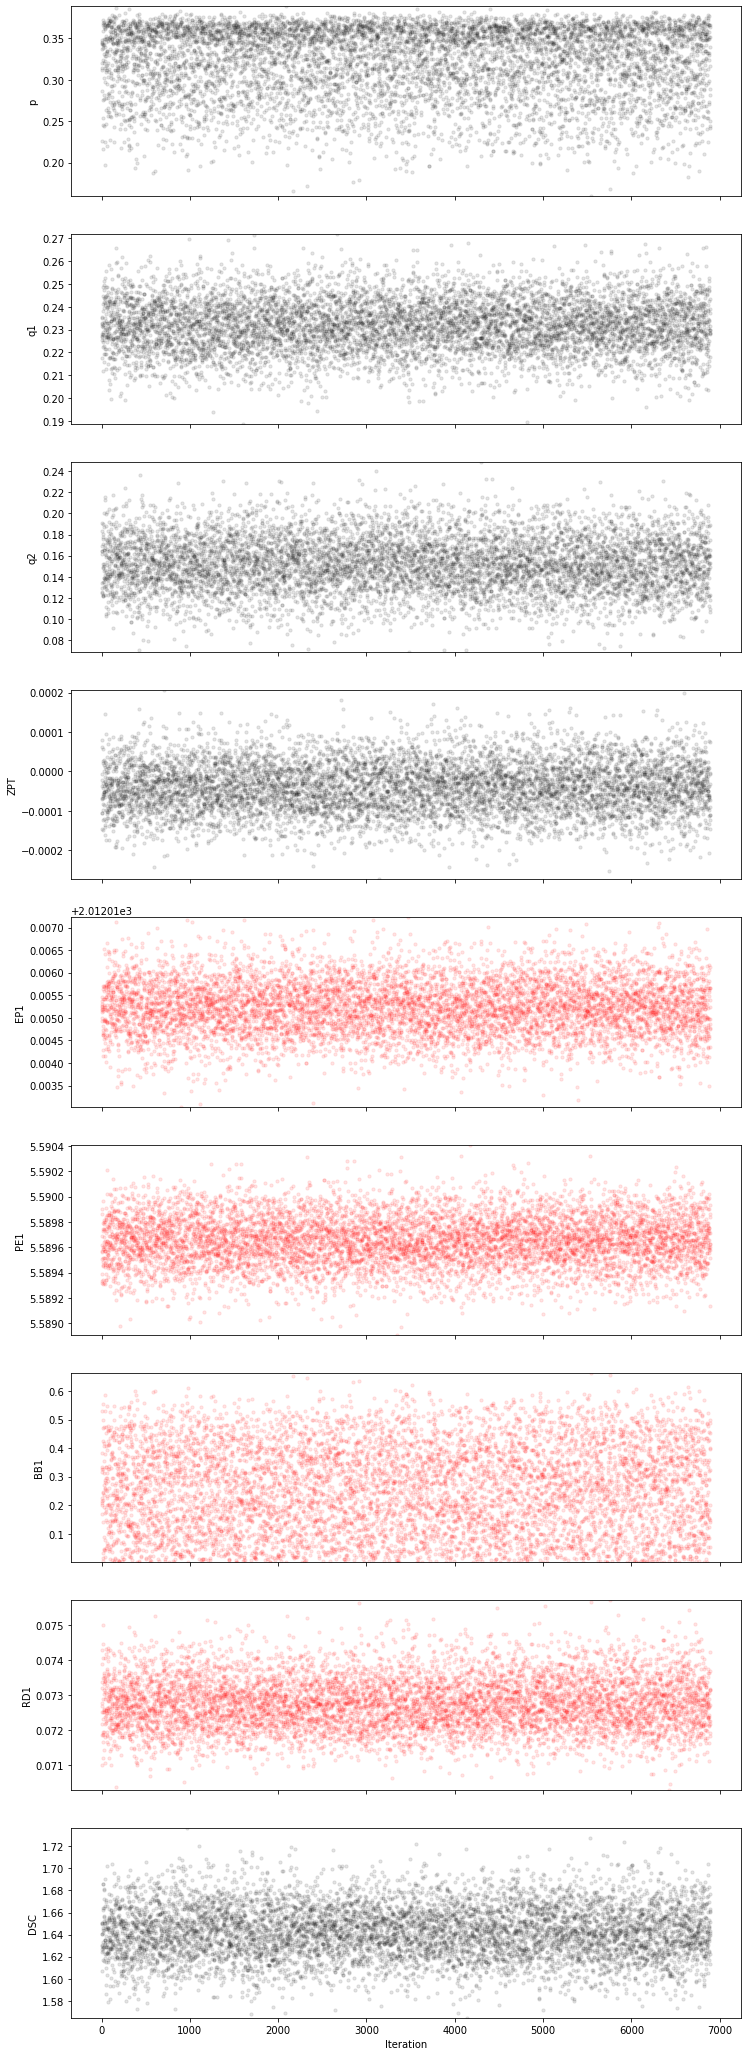

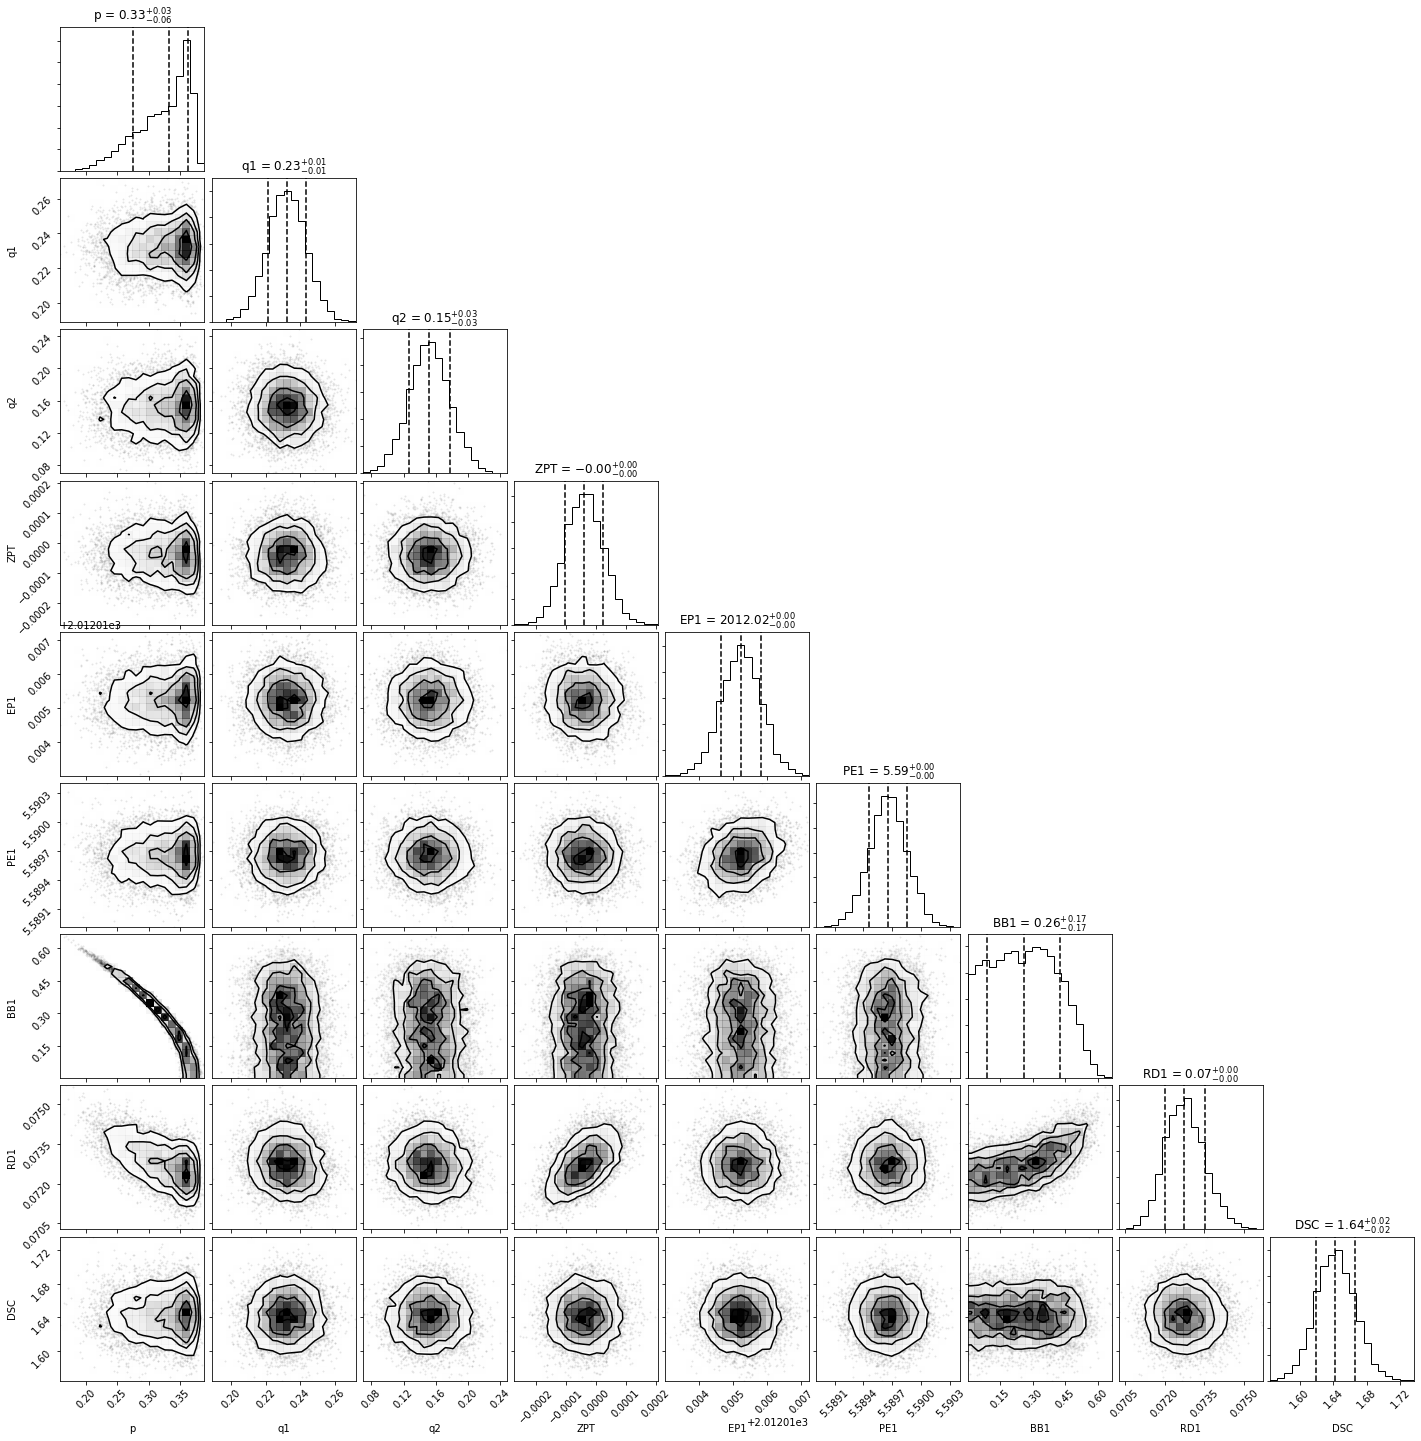

In [10]:
resultsdir="./results/" #Where to store results for each TOI

nbin=30 #binning for histograms
nthin=97 #plot every n'th parameter (this thins the chain)
burninfrac=0.5 #How much of the initial chain is burnin (fraction)

modeltype=[1,0,0,0] #first digit ld: 0-no, 1-yes; second digit rhostar prior: 0-no, 1-yes; 3rd digit eccentricity.

check_mcmc(exocat.toiid[toi_index],resultsdir,nbin,nthin,burninfrac,modeltype)